In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Models/GDSC_PDX_TCGA_Third_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Models/GDSC_PDX_TCGA_Third_Strategy/Third_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
paclitaxel_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/Paclitaxel/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Figures/GDSC_PDX_TCGA_Third_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read cell line details table in GDSC

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details = GDSC_cell_line_details.iloc[:-1,]
GDSC_cell_line_details.index = GDSC_cell_line_details.index.astype(str)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1299069,TMK-1,Y,Y,N,N,Y,digestive_system,stomach,STAD,,R,Adherent
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent


In [6]:
# change directory to read GDSC expression dataset (CYTOi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (CYTOi)
# remove samples with shared cancer types from training dataset

GDSCE = pd.read_csv("GDSC_exprs.z.CYTOi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE = pd.merge(GDSC_cell_line_details,
         GDSCE,
         left_index = True,
         right_index = True)
filter = (GDSCE["GDSC\nTissue descriptor 1"] != "breast") & \
         (GDSCE["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "HNSC") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "UCS") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "BRCA")
GDSCE = GDSCE.loc[filter,]
GDSCE.drop(GDSC_cell_line_details.columns, axis = 1, inplace = True)
GDSCE.index = GDSCE.index.astype(int)
GDSCE.head(3)

,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
906794,-0.523146241125996,-0.4774107580335559,1.1792180707204845,-0.1950133103016388,0.2086331356678636,0.1512743407965193,-1.0570300318558898,0.1189857462468134,-1.60237161712403,0.0522097313574845,...,0.4777943283680773,1.7440832645129538,-0.1411845263288239,1.550275627132598,1.7625075247186934,-0.9885319787599142,-1.398962216984746,-1.1477981243123072,0.2309989847175704,0.1184597758225788
1240140,-1.1535150359007529,1.4620213527326855,-0.965108789677278,-0.0314750544816065,0.8094864727339984,1.2627974489364528,0.2033960718348468,-0.4474006981252838,-1.3410784477374655,1.3203071282432897,...,-1.2559664440643965,-1.4745946838546486,0.1348463500228829,1.4266569981962234,0.1767187952771288,0.4398466959212178,-0.495214909082466,-0.4887641875217435,0.7250217042275812,3.27209257331072
906817,0.2276887973157341,-0.3436044981967705,0.6657758797716999,-0.3936384476559742,1.4007701559387662,0.6361576789633872,-0.2543778920432356,0.0679058100162108,0.7151957733796306,0.0206057160264341,...,-0.6037601461509517,-1.0146481580459186,-1.3765096564208084,0.5180021606770674,-1.198229411071783,-1.053034871859647,0.5770925059303792,-0.7597235535092631,0.4063539588219202,-0.9232764637812318


In [8]:
# change directory to read GDSC CNA dataset (CYTOi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [9]:
# read GDSC CNA dataset (CYTOi)
# remove samples with shared cancer types from training dataset

GDSCC = pd.read_csv("GDSC_CNA.CYTOi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]
GDSCC = pd.merge(GDSC_cell_line_details,
                 GDSCC,
                 left_index=True,
                 right_index=True)
filter = (GDSCC["GDSC\nTissue descriptor 1"] != "breast") & \
         (GDSCC["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCC["Cancer Type\n(matching TCGA label)"] != "HNSC") & \
         (GDSCC["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCC["Cancer Type\n(matching TCGA label)"] != "UCS") & \
         (GDSCC["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCC["Cancer Type\n(matching TCGA label)"] != "BRCA")
GDSCC = GDSCC.loc[filter, ]
GDSCC.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCC.index = GDSCC.index.astype(int)

GDSCC.head()

,1,2,9,10,12,13,14,15,16,18,...,107133486,107133502,107133524,107161145,107985535,107986809,107987337,107987341,109731405,112441434
906794,-0.584963,-0.584963,0.415037,0.415037,-0.584963,0.736966,0.000000,-0.584963,-0.584963,0.415037,...,0.415037,-4.320000,0.415037,0.000000,0.0,0.0,-4.320000,-4.320000,-0.584963,0.000000
1240140,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.584963,0.000000,0.000000,0.000000,0.000000,...,0.000000,-4.320000,0.000000,0.000000,0.0,0.0,-4.320000,-4.320000,0.000000,0.000000
906817,0.000000,0.000000,-0.584963,-0.584963,0.415037,0.000000,-0.584963,0.415037,0.415037,-0.584963,...,0.000000,0.000000,0.000000,-0.584963,0.0,0.0,-4.320000,-4.320000,0.415037,0.000000
753555,0.000000,0.736966,-0.584963,-0.584963,0.415037,0.415037,-0.584963,0.415037,0.736966,0.415037,...,0.000000,-1.584963,0.415037,0.000000,0.0,0.0,-1.584963,-4.320000,0.736966,-0.584963
1503366,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.584963,0.000000,-1.000000,0.000000,...,0.000000,2.807355,-1.000000,0.000000,-1.0,0.0,-1.000000,2.459432,-1.000000,-1.000000


In [10]:
# change directory to read GDSC response dataset (CYTOi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (CYTOi)
# remove samples with shared cancer types from training dataset

GDSCR = pd.read_csv("GDSC_response.CYTOi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = pd.merge(GDSC_cell_line_details,
                 GDSCR,
                 left_index=True,
                 right_index=True)
filter = (GDSCR["GDSC\nTissue descriptor 1"] != "breast") & \
         (GDSCR["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "HNSC") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "UCS") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "BRCA")
GDSCR = GDSCR.loc[filter, ]
GDSCR.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCR.index = GDSCR.index.astype(int)

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,
906794,0,-4.02193345692394,Paclitaxel,1,1,1
906794,0,4.08827572251529,GSK269962A,1,1,1
906794,1,-6.33038616970938,Vinorelbine,1,1,1
906794,0,1.24194812524286,PF-562271,1,1,1
906794,0,2.7176429750138,IPA-3,1,1,1


In [12]:
# print count of cell lines for each drug (CYTOi)

GDSCR["drug"].value_counts()

drug
Vinorelbine     591
GSK429286A      588
Y-39983         587
Epothilone B    583
IPA-3           582
PF-562271       581
EHT 1864        580
Vinblastine     562
Docetaxel       562
Paclitaxel      328
GSK269962A      309
Name: count, dtype: int64

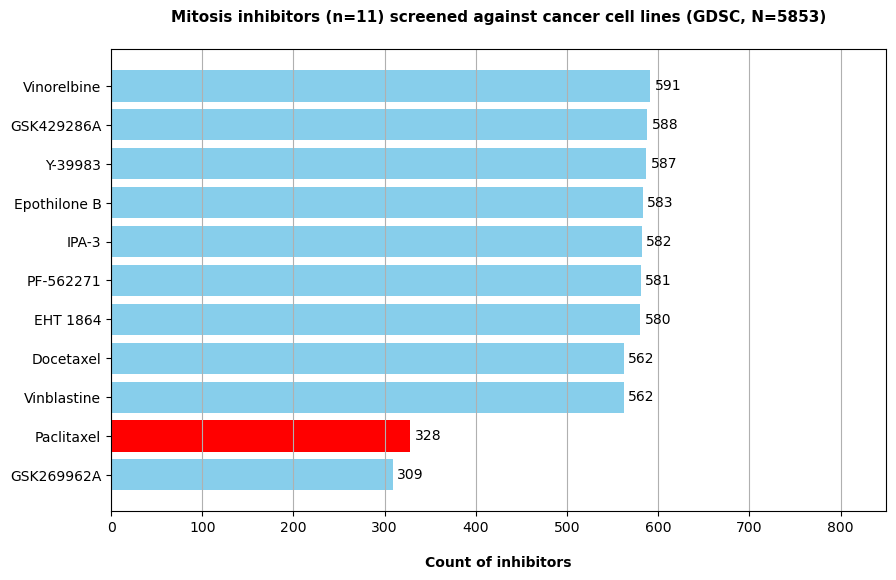

In [13]:
# plot cytoskeleton inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Paclitaxel":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'Mitosis inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'Mitosis Inhibitors with Their Counts (GDSC, Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

PDXEpaclitaxel = pd.read_csv("PDX_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEpaclitaxel = pd.DataFrame.transpose(PDXEpaclitaxel)
PDXEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1008,5.1683455924601,6.40148605928778,5.14735257900894,2.62182669498089,5.65801642244848,2.56126582112594,7.9002150761815,2.99037104024989,9.07138836072349,2.93107188443328,...,2.51273514040916,3.16885840754458,7.88710414124411,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,3.95569877310649,3.86826539821721,2.24540260166309
X-1156,5.64285976724198,6.16403060339034,6.56682953977831,2.62182669498089,2.20555612143949,2.68000643826337,8.28747895280708,2.40648953950849,6.85807798266578,3.44682372154383,...,2.6201404525098,3.05224139425924,6.43259864910441,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,5.32315076936616,3.85690425090814,2.27121625384186
X-1172,2.76326591576383,6.63737682195879,5.67675838505579,2.79473965144091,3.52596051559272,5.74258764261314,8.70184553811941,2.66283398075993,9.95397018105127,3.64884172474159,...,2.68566229198938,3.11779249946595,5.44497097056128,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,2.45399733779172,4.19271392722119,2.21127349569176


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Paclitaxel)

TCGAEpaclitaxel = pd.read_csv("TCGA_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEpaclitaxel = pd.DataFrame.transpose(TCGAEpaclitaxel)
TCGAEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-50-5068-01A,6.07077606939576,4.22435549873448,6.09703453175451,2.79409553041956,2.16511492655888,6.23897149546054,7.50971824388108,2.62136482478483,6.78739521681224,2.98021984531206,...,9.80444787373941,2.79886640790268,2.81581286530484,3.00085815257311,2.80511713535762,2.40148864399763,2.58029798170468,3.80309726320581,2.93775838077045,3.15136733303223
TCGA-53-7624-01A,3.36417856158271,1.84257380220382,4.89461611130517,3.01203072800212,1.08675483906125,2.65397613649159,8.19887134647799,2.64492131772784,9.57693655417731,2.75400746416671,...,9.87655475612095,2.79886640790268,2.81581286530484,3.47072364084828,2.92631228926461,3.04342978048926,3.85945702517433,2.76860237341666,4.70753879715127,4.40422733195751
TCGA-99-8033-01A,3.17759663469389,4.069358321802,5.30291306958158,3.04306111581331,1.71759129803103,2.9492322528108,8.35388516673678,2.61215713067395,9.55148283225251,2.62363654845594,...,9.97545462791267,2.79886640790268,2.81581286530484,3.61434933029633,2.82800183535407,2.62335146413649,2.82601101115657,2.76860237341666,4.83367880098437,4.96091320806586


In [17]:
# change directory to read PDX CNA dataset (Paclitaxel)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [18]:
# read PDX CNA dataset (Paclitaxel)

PDXCpaclitaxel = pd.read_csv("PDX_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXCpaclitaxel.drop_duplicates(keep='last')
PDXCpaclitaxel = pd.DataFrame.transpose(PDXCpaclitaxel)
PDXCpaclitaxel = PDXCpaclitaxel.loc[:, ~PDXCpaclitaxel.columns.duplicated()]

PDXCpaclitaxel.head(3)

ENTREZID,1,2,3,9,10,12,13,14,15,16,...,101340252,102723547,102724473,103091865,105375355,107126285,109623460,109731405,118126072,128385369
X-1008,-0.3219280948873623,0.0,0.0,-1.6896598793878497,-1.6896598793878497,0.0,0.6182386555954547,-0.5145731728297583,0.0,-0.3400754415976217,...,0.3276873641760471,-0.3219280948873623,0.3785116232537298,0.0,-0.3129393116601076,0.0,-1.888968687611256,-0.3400754415976217,-0.7369655941662062,0.0
X-1156,0.9781956296816516,0.7004397181410922,0.7004397181410922,-0.2429767534925404,-0.2429767534925404,-0.2863041851566411,0.5607149544744789,0.3895668117627256,-0.2688167584278,-0.2688167584278,...,0.4594316186372972,0.0,-0.4246876693125631,-0.7369655941662062,0.0,1.100977647724821,-0.3770696490798233,-0.3219280948873623,-0.6551715030025588,0.0
X-1172,0.0,0.0,0.0,-0.5145731728297583,-0.5145731728297583,0.0,0.4276061727818994,0.4222330006830478,0.9297909977185974,0.0,...,-0.5994620704162712,-0.6780719051126377,0.3895668117627256,-0.4639470997597902,0.859969548221026,0.5109619192773793,-0.2863041851566411,0.0,0.0,1.0214797274104517


In [19]:
# read TCGA CNA dataset (Paclitaxel)

TCGACpaclitaxel = pd.read_csv("TCGA_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGACpaclitaxel.drop_duplicates(keep='last')
TCGACpaclitaxel = pd.DataFrame.transpose(TCGACpaclitaxel)
TCGACpaclitaxel = TCGACpaclitaxel.loc[:, ~TCGACpaclitaxel.columns.duplicated()]

TCGACpaclitaxel.head(3)

gene,1,2,3,9,10,11,12,13,14,15,...,100653016,100653017,100653018,100653019,100653020,100653021,100653022,100653023,100653024,100653025
TCGA-50-5068-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7624-01A,1,0,0,-1,-1,-1,0,0,0,1,...,-1,1,1,-1,1,0,1,-1,-1,1
TCGA-99-8033-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# variance threshold for GDSC expression dataset (CYTOi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC CNA dataset (CYTOi)

GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and CNA datasets 

ls = GDSCE.columns.intersection(GDSCC.columns)
ls = ls.intersection(PDXEpaclitaxel.columns)
ls = ls.intersection(PDXCpaclitaxel.columns)
ls = ls.intersection(TCGAEpaclitaxel.columns)
ls = ls.intersection(TCGACpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 17839


In [23]:
# select shared samples between GDSC expression, CNA, and response datasets (CYTOi)

ls2 = GDSCE.index.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 611


In [24]:
# subset shared genes and samples in GDSC expression, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (611, 17839)
GDSC # of common samples and genes (CNA): (611, 17839)
GDSC # of samples (Response): 5853


In [25]:
# select shared samples between PDX expression and CNA datasets (Paclitaxel) 

ls3 = PDXEpaclitaxel.index.intersection(PDXCpaclitaxel.index)

print(f"PDX # of common samples (Paclitaxel): {ls3.shape[0]}")

PDX # of common samples (Paclitaxel): 43


In [26]:
# select shared samples between TCGA expression and CNA datasets (Paclitaxel) 

ls4 = TCGAEpaclitaxel.index.intersection(TCGACpaclitaxel.index)

print(f"TCGA # of common samples (Paclitaxel): {ls4.shape[0]}")

TCGA # of common samples (Paclitaxel): 35


In [27]:
# select shared genes and samples between PDX and TCGA expression and CNA datasets (Paclitaxel)

PDXEpaclitaxel = PDXEpaclitaxel.loc[ls3, ls]
PDXCpaclitaxel = PDXCpaclitaxel.loc[ls3, ls]

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[ls4, ls]
TCGACpaclitaxel = TCGACpaclitaxel.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Paclitaxel): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for CNA (Paclitaxel): {PDXCpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Paclitaxel): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for CNA (Paclitaxel): {TCGACpaclitaxel.shape}")

PDX # of common samples and genes for Expression (Paclitaxel): (43, 17839)
PDX # of common samples and genes for CNA (Paclitaxel): (43, 17839)

TCGA # of common samples and genes for Expression (Paclitaxel): (35, 17839)
TCGA # of common samples and genes for CNA (Paclitaxel): (35, 17839)


In [28]:
# change directory to read DEGs (CYTOi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi


In [29]:
# read DEGs (CYTOi)

DEGs_filtered_data = pd.read_excel("CYTOi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among cytoskeleton inhibitors\n")

DEGs_filtered_data.head()

There are 845 DEGs (p-adjusted < 0.05 and |logFC| > 1) among cytoskeleton inhibitors



,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


845

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
cna = GDSCC
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
906794,0,-4.02193345692394,Paclitaxel,1,1,1
906794,0,4.08827572251529,GSK269962A,1,1,1
906794,1,-6.33038616970938,Vinorelbine,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Docetaxel',
 'EHT 1864',
 'Epothilone B',
 'GSK269962A',
 'GSK429286A',
 'IPA-3',
 'PF-562271',
 'Paclitaxel',
 'Vinblastine',
 'Vinorelbine',
 'Y-39983'}

In [34]:
# convert the indices of GDSC datasets to string
GDSCE.index = GDSCE.index.astype(str)
GDSCC.index = GDSCC.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
dat.head(3)

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,,,,,,,,,,,,,
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-4.02193345692394,Paclitaxel,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,4.08827572251529,GSK269962A,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,1,-6.33038616970938,Vinorelbine,1,1,1


In [36]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    467
glioma                       451
melanoma                     418
large_intestine              355
B_cell_lymphoma              284
Name: count, dtype: int64

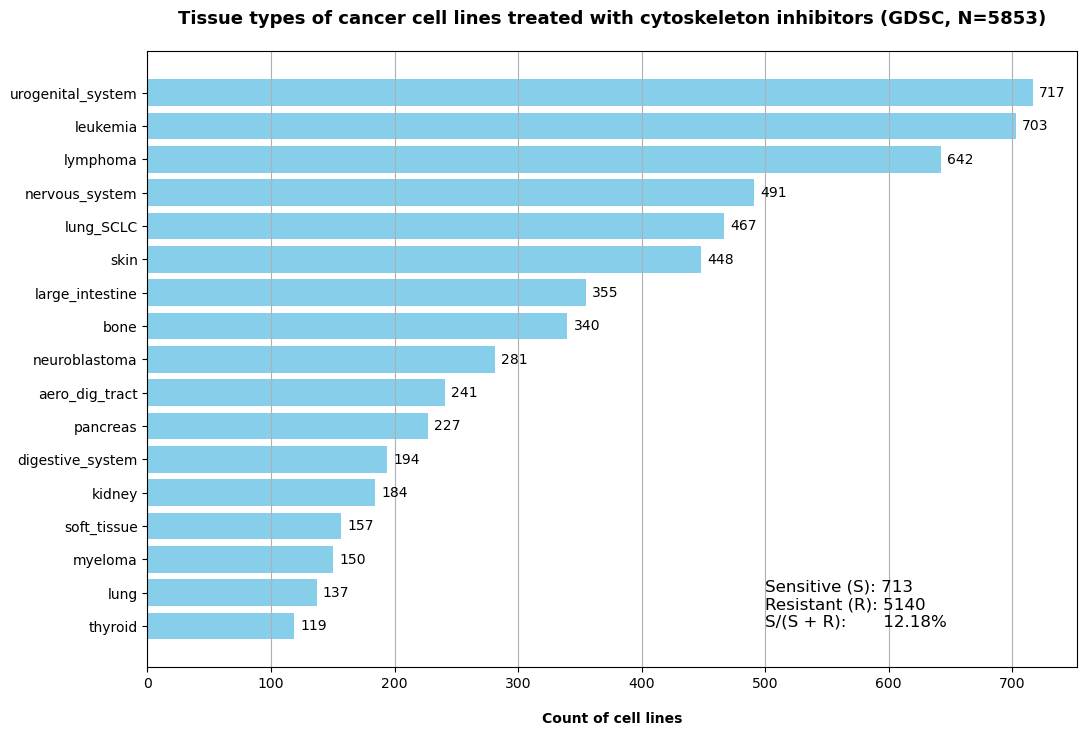

In [37]:
# plot tissue types of cancer cell lines treated with cytoskeleton inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with cytoskeleton inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))


plt.text(500, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with cytoskeleton inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [38]:
# list count of cell lines as to tissues treated with paclitaxel

filter = (dat["drug"] == "Paclitaxel")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             64
lymphoma             57
lung_SCLC            35
nervous_system       25
neuroblastoma        23
bone                 20
skin                 19
urogenital_system    16
large_intestine      15
myeloma              13
kidney               10
aero_dig_tract       10
soft_tissue           9
digestive_system      5
lung                  3
pancreas              2
thyroid               2
Name: count, dtype: int64

In [39]:
# list count of cell lines as to tissues treated with paclitaxel

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Paclitaxel")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    35
acute_myeloid_leukaemia      25
glioma                       23
neuroblastoma                23
B_cell_lymphoma              23
Name: count, dtype: int64

In [40]:
# filter GDSC expression and CNA datasets (CYTOi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCCv2 = GDSCCv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls5]
PDXCpaclitaxel = PDXCpaclitaxel.loc[:,ls5]
TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls5]
TCGACpaclitaxel = TCGACpaclitaxel.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples and genes (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (CNA): {PDXCpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (CNA): {TCGACpaclitaxel.shape}")

GDSC # of common samples and genes (Expression): (5853, 834)
GDSC # of common samples and genes (CNA): (5853, 834)
GDSC # of common samples and genes (Response): 5853

PDX # of common samples and genes for Paclitaxel (Expression): (43, 834)
PDX # of common samples and genes for Paclitaxel (CNA): (43, 834)

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 834)
TCGA # of common samples and genes for Paclitaxel (CNA): (35, 834)


In [41]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 1 ... 0 1 1]


In [42]:
# change directory to read PDX and TCGA response datasets (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [43]:
# read PDX response dataset (Paclitaxel)

PDXRpaclitaxel = pd.read_csv("PDX_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRpaclitaxel.dropna(inplace=True)
PDXRpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRpaclitaxel["response"] = PDXRpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_pdx = PDXRpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_pdx.shape[0]} samples with response data in the PDX (Paclitaxel)\n")
Ytspaclitaxel_pdx

There are 43 samples with response data in the PDX (Paclitaxel)



array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [44]:
# read PDX dataset to select cohorts (Paclitaxel)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "paclitaxel",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1004,BRCA
X-1008,BRCA
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC


In [45]:
# merged PDX cohort table with PDX response dataset (Paclitaxel)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRpaclitaxel,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
BRCA     24
NSCLC    19
Name: count, dtype: int64

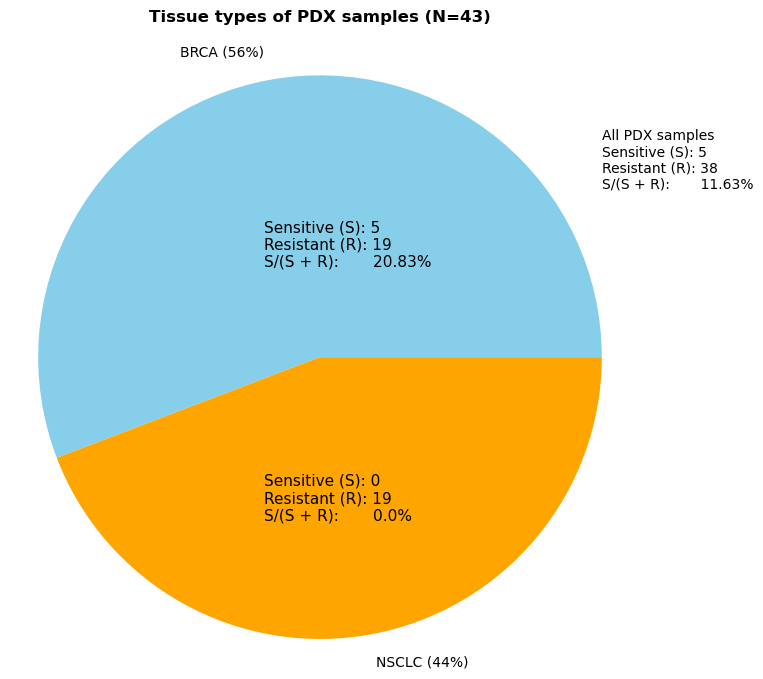

In [46]:
# plot tissue types of PDX samples 

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue','orange'])
plt.title(f'Tissue types of PDX samples (N={total})', fontweight = "bold", pad = 20)
plt.axis('equal')  

plt.text(-0.2, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.text(-0.2, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All PDX samples\nSensitive (S): {PDXRpaclitaxel["response"].value_counts()[1]} \nResistant (R): {PDXRpaclitaxel["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(PDXRpaclitaxel["response"].value_counts()[1]/(sum(PDXRpaclitaxel["response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [47]:
# filter BRCA cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "BRCA")
pdx_brca_samples = dat_pdx.loc[filter,].index
pdx_brca_samples

Index(['X-1008', 'X-1298', 'X-1371', 'X-1383', 'X-1407', 'X-1468', 'X-1600',
       'X-1916', 'X-1921', 'X-2195', 'X-2344', 'X-2487', 'X-2524', 'X-2780',
       'X-3298', 'X-3450', 'X-3873', 'X-4347', 'X-4567', 'X-4824', 'X-4949',
       'X-5502', 'X-5975', 'X-6047'],
      dtype='object')

In [48]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_pdx_brca = PDXRpaclitaxel.loc[pdx_brca_samples,"response"].values
Ytspaclitaxel_pdx_brca

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

In [49]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

PDXRpaclitaxel.loc[pdx_brca_samples,"response"].value_counts()

response
0    19
1     5
Name: count, dtype: int64

In [50]:
# filter NSCLC cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1787',
       'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980', 'X-1993', 'X-2017',
       'X-2042', 'X-2082', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [51]:
# filter responses of NSCLC cohort samples (Paclitaxel)

Ytspaclitaxel_nsclc = PDXRpaclitaxel.loc[pdx_nsclc_samples,"response"].values
Ytspaclitaxel_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
# read TCGA response dataset (Paclitaxel)

TCGARpaclitaxel = pd.read_csv("TCGA_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARpaclitaxel.dropna(inplace=True)
TCGARpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARpaclitaxel["response"] = TCGARpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_tcga = TCGARpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_tcga.shape[0]} samples with response data in the TCGA (Paclitaxel)\n")
Ytspaclitaxel_tcga

There are 35 samples with response data in the TCGA (Paclitaxel)



array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [53]:
# TCGA cohort table with TCGA response dataset (Paclitaxel)

dat_tcga = TCGARpaclitaxel["cohort"]

dat_tcga.value_counts()

cohort
BRCA    27
LUAD     3
UCS      3
STAD     1
HNSC     1
Name: count, dtype: int64

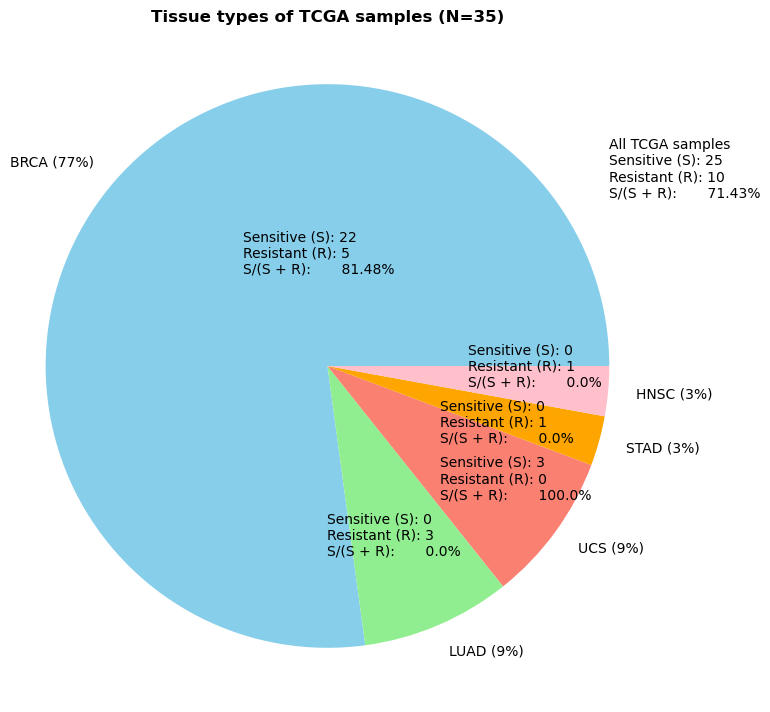

In [54]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue', 'lightgreen', 'salmon', 'orange','pink'])
plt.title(f'Tissue types of TCGA samples (N={total})', fontweight = "bold")
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.3, 0.4, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.4, -0.2, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "STAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.4, -0.4, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "UCS","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0, -0.6, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "LUAD","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(0.5, 0, 
         f'Sensitive (S): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "HNSC","response"].value_counts().get(1,0)} \nResistant (R): {TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "HNSC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "HNSC","response"].value_counts().get(1,0)/(sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "HNSC","response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARpaclitaxel["response"].value_counts()[1]} \nResistant (R): {TCGARpaclitaxel["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARpaclitaxel["response"].value_counts()[1]/(sum(TCGARpaclitaxel["response"].value_counts())) * 100, 2)}%', 
         fontsize=10, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [55]:
# filter BRCA cohort samples (Paclitaxel)

filter = (TCGARpaclitaxel["cohort"] == "BRCA")
tcga_brca_samples = dat_tcga.loc[filter,].index
tcga_brca_samples

Index(['TCGA-A2-A0EP-01A', 'TCGA-A2-A3XS-01A', 'TCGA-A2-A3XW-01A',
       'TCGA-A2-A3XX-01A', 'TCGA-A2-A3XY-01A', 'TCGA-A2-A4S2-01A',
       'TCGA-A7-A4SA-01A', 'TCGA-A7-A4SE-01A', 'TCGA-A7-A5ZV-01A',
       'TCGA-A7-A5ZX-01A', 'TCGA-A8-A08X-01A', 'TCGA-A8-A09M-01A',
       'TCGA-AQ-A54O-01A', 'TCGA-B6-A402-01A', 'TCGA-D8-A3Z6-01A',
       'TCGA-EW-A1OY-01A', 'TCGA-EW-A1P3-01A', 'TCGA-EW-A2FR-01A',
       'TCGA-GM-A2DA-01A', 'TCGA-GM-A2DB-01A', 'TCGA-GM-A2DF-01A',
       'TCGA-GM-A2DH-01A', 'TCGA-GM-A2DM-01A', 'TCGA-GM-A2DN-01A',
       'TCGA-GM-A3XG-01A', 'TCGA-GM-A3XL-01A', 'TCGA-GM-A3XN-01A'],
      dtype='object', name='sample')

In [56]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_tcga_brca = TCGARpaclitaxel.loc[tcga_brca_samples,"response"].values
Ytspaclitaxel_tcga_brca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1])

In [57]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

TCGARpaclitaxel.loc[tcga_brca_samples,"response"].value_counts()

response
1    22
0     5
Name: count, dtype: int64

In [58]:
# maximum iteration

max_iter = 50

In [59]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 128
hdm2 = 256
rate1 = 0.6
rate2 = 0.6
rate3 = 0.7

In [60]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel_pdx = scalerGDSC.transform(PDXEpaclitaxel.values) 
X_testEpaclitaxel_pdx_brca = scalerGDSC.transform(PDXEpaclitaxel.loc[pdx_brca_samples,].values) 

X_testEpaclitaxel_tcga = scalerGDSC.transform(TCGAEpaclitaxel.values)    
X_testEpaclitaxel_tcga_brca = scalerGDSC.transform(TCGAEpaclitaxel.loc[tcga_brca_samples,].values)    

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCpaclitaxel_pdx = np.nan_to_num(PDXCpaclitaxel.values.astype(np.float32))
X_testCpaclitaxel_pdx_brca = np.nan_to_num(PDXCpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))
X_testCpaclitaxel_tcga = np.nan_to_num(TCGACpaclitaxel.values)
X_testCpaclitaxel_tcga_brca = np.nan_to_num(TCGACpaclitaxel.loc[tcga_brca_samples,].values)

TX_testEpaclitaxel_pdx = torch.FloatTensor(X_testEpaclitaxel_pdx)
TX_testEpaclitaxel_pdx_brca = torch.FloatTensor(X_testEpaclitaxel_pdx_brca)

TX_testCpaclitaxel_pdx = torch.FloatTensor(X_testCpaclitaxel_pdx.astype(np.float32))
TX_testCpaclitaxel_pdx_brca = torch.FloatTensor(X_testCpaclitaxel_pdx_brca.astype(np.float32))

ty_testEpaclitaxel_pdx = torch.FloatTensor(Ytspaclitaxel_pdx.astype(int))

ty_testEpaclitaxel_pdx_brca = torch.FloatTensor(Ytspaclitaxel_pdx_brca.astype(int))

TX_testEpaclitaxel_tcga = torch.FloatTensor(X_testEpaclitaxel_tcga)
TX_testEpaclitaxel_tcga_brca = torch.FloatTensor(X_testEpaclitaxel_tcga_brca)

TX_testCpaclitaxel_tcga = torch.FloatTensor(X_testCpaclitaxel_tcga.astype(np.float32))
TX_testCpaclitaxel_tcga_brca = torch.FloatTensor(X_testCpaclitaxel_tcga_brca.astype(np.float32))

ty_testEpaclitaxel_tcga = torch.FloatTensor(Ytspaclitaxel_tcga.astype(int))
ty_testEpaclitaxel_tcga_brca = torch.FloatTensor(Ytspaclitaxel_tcga_brca.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output     

class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnC(x)
        return output 
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy.pt")
AutoencoderC = torch.load(models_dir + "CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy.pt")

Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy.pt")

AutoencoderE.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (CYTOi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (CYTOi): {round(AUCTaucpr,2)}\n")

ZETpaclitaxel_pdx = AutoencoderE(TX_testEpaclitaxel_pdx)
ZCTpaclitaxel_pdx = AutoencoderC(TX_testCpaclitaxel_pdx)
ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZCTpaclitaxel_pdx), 1)
ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
PredTpaclitaxel_pdx = Clas(ZTTpaclitaxel_pdx)
AUCTpaclitaxel_pdx = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
AUCTpaclitaxel_pdx_aucpr = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())

ZETpaclitaxel_pdx_brca = AutoencoderE(TX_testEpaclitaxel_pdx_brca)
ZCTpaclitaxel_pdx_brca = AutoencoderC(TX_testCpaclitaxel_pdx_brca)
ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZCTpaclitaxel_pdx_brca), 1)
ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
PredTpaclitaxel_pdx_brca = Clas(ZTTpaclitaxel_pdx_brca)
AUCTpaclitaxel_pdx_brca = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
AUCTpaclitaxel_pdx_brca_aucpr = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())

ZETpaclitaxel_tcga = AutoencoderE(TX_testEpaclitaxel_tcga)
ZCTpaclitaxel_tcga = AutoencoderC(TX_testCpaclitaxel_tcga)
ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZCTpaclitaxel_tcga), 1)
ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
PredTpaclitaxel_tcga = Clas(ZTTpaclitaxel_tcga)
AUCTpaclitaxel_tcga = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
AUCTpaclitaxel_tcga_aucpr = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())

ZETpaclitaxel_tcga_brca = AutoencoderE(TX_testEpaclitaxel_tcga_brca)
ZCTpaclitaxel_tcga_brca = AutoencoderC(TX_testCpaclitaxel_tcga_brca)
ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZCTpaclitaxel_tcga_brca), 1)
ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
PredTpaclitaxel_tcga_brca = Clas(ZTTpaclitaxel_tcga_brca)
AUCTpaclitaxel_tcga_brca = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
AUCTpaclitaxel_tcga_brca_aucpr = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_pdx_finetuned = dict()
AUCTpaclitaxel_tcga_finetuned = dict()
AUCTpaclitaxel_pdx_brca_finetuned = dict()
AUCTpaclitaxel_tcga_brca_finetuned = dict()
AUCTpaclitaxel_pdx_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_aucpr_finetuned = dict()
AUCTpaclitaxel_pdx_brca_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
    iter += 1  
    
    AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{iter}.pt")
    AutoencoderC_finetuned = torch.load(finetuned_dir + f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{iter}.pt")
    Clas_finetuned = torch.load(finetuned_dir + f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{iter}.pt")
   
    AutoencoderE_finetuned.eval()
    AutoencoderC_finetuned.eval()
    Clas_finetuned.eval()
      
    ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
    ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
    ZTX = torch.cat((ZEX, ZCX), 1)
    ZTX = F.normalize(ZTX, p=2, dim=0)
    PredX = Clas_finetuned(ZTX)
    AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
    AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
    ZETpaclitaxel_pdx = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx)
    ZCTpaclitaxel_pdx = AutoencoderC_finetuned(TX_testCpaclitaxel_pdx)
    ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZCTpaclitaxel_pdx), 1)
    ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
    PredTpaclitaxel_pdx = Clas_finetuned(ZTTpaclitaxel_pdx)
    AUCTpaclitaxel_pdx_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
    AUCTpaclitaxel_pdx_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())

    ZETpaclitaxel_pdx_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx_brca)
    ZCTpaclitaxel_pdx_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_pdx_brca)
    ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZCTpaclitaxel_pdx_brca), 1)
    ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
    PredTpaclitaxel_pdx_brca = Clas_finetuned(ZTTpaclitaxel_pdx_brca)
    AUCTpaclitaxel_pdx_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
    AUCTpaclitaxel_pdx_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())

    ZETpaclitaxel_tcga = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga)
    ZCTpaclitaxel_tcga = AutoencoderC_finetuned(TX_testCpaclitaxel_tcga)
    ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZCTpaclitaxel_tcga), 1)
    ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
    PredTpaclitaxel_tcga = Clas_finetuned(ZTTpaclitaxel_tcga)
    AUCTpaclitaxel_tcga_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
    AUCTpaclitaxel_tcga_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
 
    ZETpaclitaxel_tcga_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga_brca)
    ZCTpaclitaxel_tcga_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_tcga_brca)
    ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZCTpaclitaxel_tcga_brca), 1)
    ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
    PredTpaclitaxel_tcga_brca = Clas_finetuned(ZTTpaclitaxel_tcga_brca)
    AUCTpaclitaxel_tcga_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
    AUCTpaclitaxel_tcga_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

max_key_pdx = max(AUCTpaclitaxel_pdx_aucpr_finetuned, key=AUCTpaclitaxel_pdx_aucpr_finetuned.get)
max_key_pdx_brca = max(AUCTpaclitaxel_pdx_brca_aucpr_finetuned, key=AUCTpaclitaxel_pdx_brca_aucpr_finetuned.get)
max_key_tcga = max(AUCTpaclitaxel_tcga_aucpr_finetuned, key=AUCTpaclitaxel_tcga_aucpr_finetuned.get)
max_key_tcga_brca = max(AUCTpaclitaxel_tcga_brca_aucpr_finetuned, key=AUCTpaclitaxel_tcga_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (CYTOi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (CYTOi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}")
print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_pdx_brca],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_tcga_brca],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel, PDX)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Paclitaxel, PDX, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_pdx_brca}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Third_Strategy_Finetuned_{max_key_tcga_brca}.pt")


GDSC - Training AUC (CYTOi): 0.77
GDSC - Training AUCPR (CYTOi): 0.3
PDX - Test AUC (Paclitaxel): 0.47
PDX - Test AUCPR (Paclitaxel): 0.15
PDX - Test AUC (Paclitaxel, BRCA): 0.4
PDX - Test AUCPR (Paclitaxel, BRCA): 0.23
TCGA - Test AUC (Paclitaxel): 0.61
TCGA - Test AUCPR (Paclitaxel): 0.79
TCGA - Test AUC (Paclitaxel, BRCA): 0.46
TCGA - Test AUCPR (Paclitaxel, BRCA): 0.85

GDSC - Training AUC (CYTOi, Finetuned): 0.78
GDSC - Training AUCPR (CYTOi, Finetuned): 0.31
PDX - Test AUC (Paclitaxel, Finetuned): 0.52
PDX - Test AUCPR (Paclitaxel, Finetuned): 0.21

GDSC - Training AUC (CYTOi, Finetuned): 0.73
GDSC - Training AUCPR (CYTOi, Finetuned): 0.26
PDX - Test AUC (Paclitaxel, BRCA, Finetuned): 0.55
PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): 0.42

GDSC - Training AUC (CYTOi, Finetuned): 0.73
GDSC - Training AUCPR (CYTOi, Finetuned): 0.26
TCGA - Test AUC (Paclitaxel, Finetuned): 0.68
TCGA - Test AUCPR (Paclitaxel, Finetuned): 0.86

GDSC - Training AUC (CYTOi, Finetuned): 0.73
GDSC - Tr

In [61]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=834, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [62]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=834, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [63]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=384, out_features=1, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Sigmoid()
  )
)

In [66]:
# create a dataframe with the prediction results 

ec = {"Data": ["Expr + CNA", "Expr + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTpaclitaxel_pdx,2), round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTpaclitaxel_pdx_aucpr,2), round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-BRCA)":  [round(AUCTpaclitaxel_pdx_brca,2), round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)],
       "AUCPR (PDX-BRCA)": [round(AUCTpaclitaxel_pdx_brca_aucpr,2), round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)],
       "AUC (TCGA)": [round(AUCTpaclitaxel_tcga,2), round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTpaclitaxel_tcga_aucpr,2), round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-BRCA)":  [round(AUCTpaclitaxel_tcga_brca,2), round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)],
       "AUCPR (TCGA-BRCA)": [round(AUCTpaclitaxel_tcga_brca_aucpr,2), round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

ec_dataframe = pd.DataFrame.from_dict(ec, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
ec_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_CNA_CYTOi_Paclitaxel_Third_Strategy.tsv",
                    sep = "\t",
                    index = False)

ec_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUC (PDX-BRCA)": "AUC (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUCPR (PDX-BRCA)": "AUCPR (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUC (TCGA-BRCA)": "AUC (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")",
    "AUCPR (TCGA-BRCA)": "AUCPR (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")"
    }, inplace = True
)

ec_dataframe

,Data,"AUC (GDSC, N=5853)","AUCPR (GDSC, N=5853)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + CNA,0.77,0.3,0.47,0.15,0.4,0.23,0.61,0.79,0.46,0.85,5853,834
1,Expr + CNA (Fine-tuned),0.78,0.31,0.52,0.21,0.55,0.42,0.68,0.86,0.55,0.87,5853,834


In [68]:
# merge all EM, EC, and EMC dataframes 

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_CYTOi_Paclitaxel_Third_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = ec_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_PDX_TCGA_Expression_Mutation_CYTOi_Paclitaxel_Third_Strategy.tsv",
                           sep = "\t")
em_dataframe.columns = ec_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=5853)","AUCPR (GDSC, N=5853)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,
Expr + Mut + CNA,0.78,0.3,0.44,0.12,0.29,0.17,0.66,0.82,0.55,0.87,5853,707
Expr + Mut + CNA (Fine-tuned),0.79,0.3,0.52,0.23,0.47,0.29,0.67,0.83,0.62,0.88,5853,707
Expr + CNA,0.77,0.3,0.47,0.15,0.4,0.23,0.61,0.79,0.46,0.85,5853,834
Expr + CNA (Fine-tuned),0.78,0.31,0.52,0.21,0.55,0.42,0.68,0.86,0.55,0.87,5853,834
Expr + Mut,0.76,0.31,0.27,0.09,0.36,0.19,0.36,0.63,0.42,0.8,5853,708
Expr + Mut (Fine-tuned),0.77,0.32,0.34,0.1,0.42,0.22,0.5,0.76,0.55,0.86,5853,708


In [69]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                               f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                               f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                               f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=5853, p=834\nS=713, R=5140, S/N=0.12)","PDX (N=43, p=834\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=834\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=834\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=834\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.78,0.44,0.29,0.66,0.55
Expr + Mut + CNA (Fine-tuned),0.79,0.52,0.47,0.67,0.62
Expr + CNA,0.77,0.47,0.4,0.61,0.46
Expr + CNA (Fine-tuned),0.78,0.52,0.55,0.68,0.55
Expr + Mut,0.76,0.27,0.36,0.36,0.42
Expr + Mut (Fine-tuned),0.77,0.34,0.42,0.5,0.55


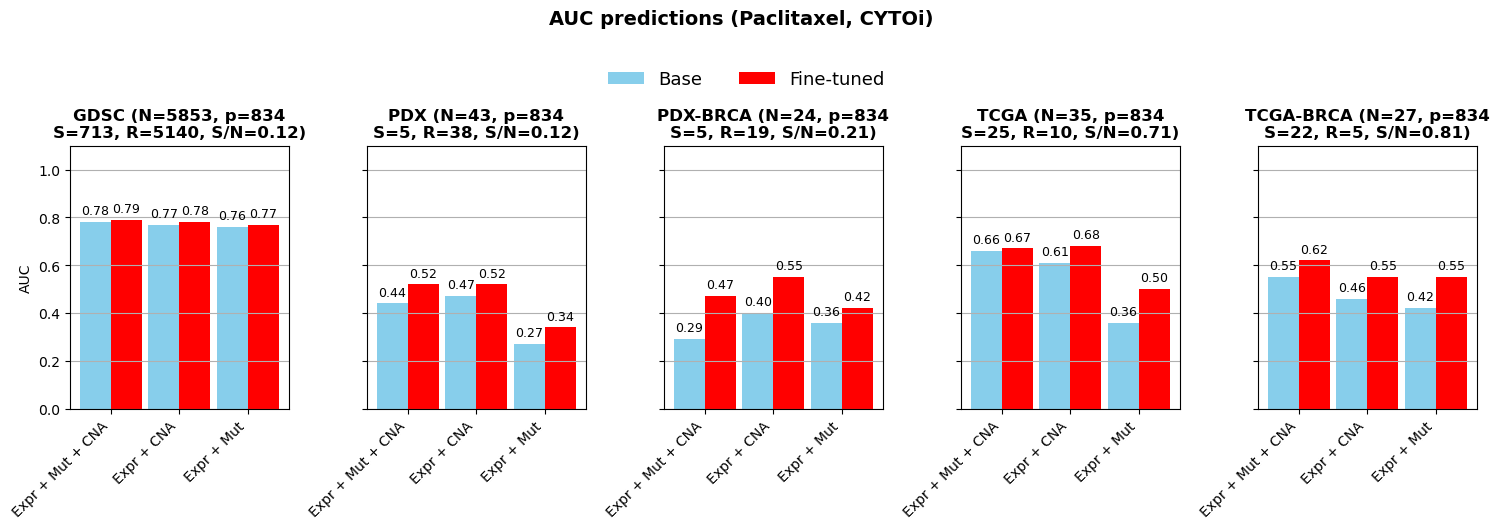

In [70]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [71]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                                 f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                                 f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                                 f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=5853, p=834\nS=713, R=5140, S/N=0.12)","PDX (N=43, p=834\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=834\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=834\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=834\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.3,0.12,0.17,0.82,0.87
Expr + Mut + CNA (Fine-tuned),0.3,0.23,0.29,0.83,0.88
Expr + CNA,0.3,0.15,0.23,0.79,0.85
Expr + CNA (Fine-tuned),0.31,0.21,0.42,0.86,0.87
Expr + Mut,0.31,0.09,0.19,0.63,0.8
Expr + Mut (Fine-tuned),0.32,0.1,0.22,0.76,0.86


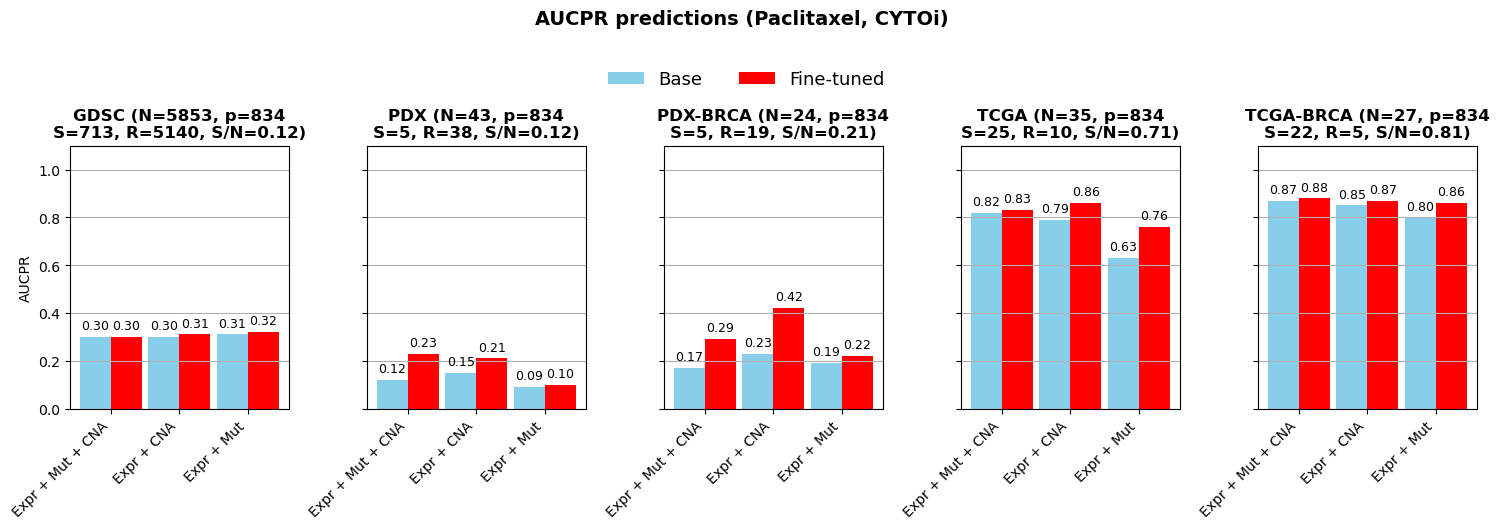

In [72]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [73]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy


In [74]:
# save predictions

file = open('GDSC_PDX_TCGA_CYTOi_Paclitaxel_Predictions_Third_Strategy (Expression and CNA).txt', 'w')
file.write(f"GDSC Training (EC) AUC (CYTOi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EC) AUCPR (CYTOi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}\n\n")

file.write(f"TCGA Test (EC) AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}\n")
file.write(f"TCGA Test (EC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EC) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}\n")
file.write(f"TCGA Test (EC) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

file.close()